In [1]:
import gc
gc.collect()

61

In [17]:
# Import comet_ml at the top of your file
# from comet_ml import Experiment


from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import swifter
import itertools
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
# import spacy                                      #need in preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy import stats

lemmatizer = WordNetLemmatizer()

# Create an experiment with your api key
# experiment = Experiment(
#     api_key="BKac2uRt0FMAlheXf6HClaZhD",
#     project_name="general",
#     workspace="sarthak7034",
# )


In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('gpu')))
# torch.cuda.is_available()

In [5]:
# # Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [6]:
# experiment.end()

In [7]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

## Cleaning Text

In [8]:
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # tokens = [token.lower() for token in tokens]          #decrease the accuracy %
    # doc = nlp(text)
    # tokens = [token.lemma_ for token in doc]                 #Spacey
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]     # Experiment with removing it!!!

    #Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    

    return words


In [9]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)


Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

In [10]:
#Replacing row with only text
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]

In [11]:
data = data[data['text'].map(len) >= 1]
#Reset index
data = data.reset_index().drop("index", axis=1)

In [12]:
df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

# # Zero Score Dataframe Normalization
# MaxMin_df = stats.zscore(df1)
# # MaxMin_df = scaler.fit_transform(df1)
# MaxMin_df.head()

In [13]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [14]:
df_merge = pd.concat([df2,df1],axis=1)
df_merge.head()

,title,text,type,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,"[At, Donald, Trump, Properties, Showcase, Bran...","[They, stood, line, Trump, Tower, sometimes, h...",real,9,21,5,6,20,5,14,30,14,52
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",real,6,7,2,4,4,4,5,9,8,15
2,"[Donald, Trump, Prepares, White, House, Move, ...","[President, Donald, J, Trump, White, House, ou...",real,5,19,6,8,15,8,6,26,15,34
3,"[Luring, Chinese, Investors, With, Trump, Name...","[An, investment, pitch, new, Texas, hotel, try...",real,11,14,6,10,10,10,6,32,24,43
4,"[Melania, Barron, Trump, Won, Immediately, Mov...","[President, Donald, J, Trump, wife, Melania, s...",real,1,12,0,3,6,2,4,14,4,25


In [15]:
# Whether any values are missing
# df2.isnull().sum()
# df1.isnull().sum()

type
fake    11731
real     8074
Name: title, dtype: int64


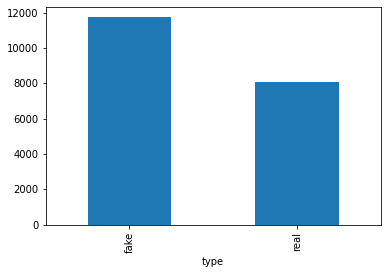

In [18]:
# How many fake and real articles?
print(df_merge.groupby(['type'])['title'].count())
df_merge.groupby(['type'])['title'].count().plot(kind="bar")
plt.show()

## Word2Vec

In [19]:
model_embed = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz",binary=True)

In [20]:
vocab_length = len(model_embed.key_to_index.keys())
print(vocab_length)                                         #Input dimension size(3000000)

3000000


In [21]:
# Applying it to the columns 

df_merge['title'] = df_merge.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['title'] if x in model_embed.key_to_index], axis=1)
df_merge['text'] = df_merge.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['text'] if x in model_embed.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [22]:
# # One-hot encoding
# encoder = LabelBinarizer().fit(list(df2['type']))
# df2['type'] = df2.swifter.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

variable_name = {'fake' : 0 , 'real' : 1 }
df_merge['type'] = df_merge['type'].map(variable_name)

In [23]:
df_merge = df_merge[df_merge['text'].map(len) >= 1]
#Reset index
df_merge = df_merge.reset_index().drop("index", axis=1)
df_merge.shape

(19672, 13)

In [24]:
# Shifting all to a new dataframe
df3 = df_merge.loc[:,['title','text','type','anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

In [25]:
# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

## Padding

In [26]:
df3['text'] = list(pad_sequences((df_merge['text']), maxlen=max_tokens_text,padding='post'))
df3['title'] = list(pad_sequences(df_merge['title'], maxlen=max_tokens_title,padding='post'))

In [27]:
df3.shape

(19672, 13)

In [28]:
#Python object serialized
df3.to_pickle('./model_data.pickle')